In [9]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

def read_tsp_coords(tsp_path):
    coords = []
    with open(tsp_path, 'r') as f:
        start = False
        for line in f:
            if 'NODE_COORD_SECTION' in line:
                start = True
                continue
            if 'EOF' in line or not start:
                continue
            parts = line.strip().split()
            if len(parts) == 3:
                _, x, y = parts
                coords.append((float(x), float(y)))
    return coords

def read_tour(tour_path):
    tour = []
    try:
        with open(tour_path, 'r') as f:
            start = False
            for line in f:
                if 'TOUR_SECTION' in line:
                    start = True
                    continue
                if not start:
                    continue
                idx = line.strip()
                if idx == '-1' or idx == '':
                    break
                tour.append(int(idx) - 1)  # 0-based index
    except:
        return None
    return tour

def plot_tour(coords, tour, title='TSP Tour', markersize=5, linewidth=0.5):
    xs = [coords[i][0] for i in tour] + [coords[tour[0]][0]]
    ys = [coords[i][1] for i in tour] + [coords[tour[0]][1]]
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='.', markersize=markersize, linestyle='-', linewidth=linewidth, color='black')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def plot_hylos_tour(dataset, markersize=5, linewidth=0.5, node_label=False):
    is_mona_lisa = dataset == 'mona-lisa100k'
    
    # Read coordinates and tour
    coords = read_tsp_coords(f'../data/{dataset}.tsp')
    tour = read_tour(f'../result/hylos_{dataset}.tour')
    
    # Read clusters
    clusters = []
    centroids = []
    cluster_order = []
    temp_centroids = {}
    temp_cluster = None
    
    with open(f'../result/hylos_{dataset}_clusters.txt', 'r') as f:
        current_cluster_num = None
        for line in f:
            line = line.strip()
            if not line:  # 빈 줄 무시
                continue
                
            if line.startswith('Cluster Order:'):
                numbers = line.split(':')[1].strip().split()
                if numbers:
                    cluster_order = [int(x)-1 for x in numbers]  # 0-based로 변환하지 않음
            elif line.startswith('Cluster') and not line.startswith('Cluster Order'):
                # 이전 클러스터가 있다면 저장
                if temp_cluster is not None and current_cluster_num is not None:
                    clusters.append(temp_cluster)
                
                # 새로운 클러스터 시작
                current_cluster_num = int(line.split()[1].rstrip(':')) - 1
                temp_cluster = []
            elif line.startswith('Centroid'):
                coords_str = line.split('(')[1].split(')')[0]
                x, y = map(float, coords_str.split(','))
                if current_cluster_num is not None:
                    temp_centroids[current_cluster_num] = (x, y)
            elif line.startswith('Cities:'):
                cities = [int(x)-1 for x in line[7:].strip().split()]  # 0-based로 변환하지 않음
                if temp_cluster is not None:
                    temp_cluster.extend(cities)
        
        # 마지막 클러스터 추가
        if temp_cluster is not None and current_cluster_num is not None:
            clusters.append(temp_cluster)
    
    if not cluster_order:
        cluster_order = list(range(len(clusters)))
    
    # 클러스터 순서대로 centroid 저장
    centroids = [temp_centroids[i] for i in range(len(clusters))]

    # Plot tour with different colors for each cluster
    plt.figure(figsize=(8, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))
    if is_mona_lisa:
        base_colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))
        colors = np.array([plt.cm.colors.to_rgba(c, alpha=1.0) * np.array([0.4, 0.4, 0.4, 1]) for c in base_colors])
    
    # Create mapping from node to cluster index
    node_to_cluster = {}
    for cluster_idx, cluster in enumerate(clusters):
        for node in cluster:
            node_to_cluster[node] = cluster_idx
    
    # Plot edges with cluster colors
    for i in range(len(tour)):
        start = tour[i]
        end = tour[(i + 1) % len(tour)]
        
        # If both nodes belong to same cluster, use cluster color
        if start in node_to_cluster and end in node_to_cluster:
            if node_to_cluster[start] == node_to_cluster[end]:
                color = colors[node_to_cluster[start]]
            else:
                # Nodes are in different clusters, use black for connecting edges
                color = 'black'
        else:
            color = 'black'
                    
        plt.plot([coords[start][0], coords[end][0]], 
                 [coords[start][1], coords[end][1]], 
                 linestyle='-', linewidth=linewidth, color=color)
    

    # Plot nodes for each cluster
    for cluster_idx, cluster in enumerate(clusters):
        xs = [coords[i][0] for i in cluster]
        ys = [coords[i][1] for i in cluster]
        plt.scatter(xs, ys, color=colors[cluster_idx], s=markersize**2, label=f'Cluster {cluster_idx+1}')
        
        # Add node labels
        if node_label:
            for node in cluster:
                plt.annotate(str(node), (coords[node][0], coords[node][1]), 
                            xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot centroids and connect them according to cluster_order
    if not is_mona_lisa:
        if cluster_order:
            # Connect centroids in the cluster order
            for i in range(len(cluster_order)):
                start = cluster_order[i]
                end = cluster_order[(i + 1) % len(cluster_order)]
                plt.plot([centroids[start][0], centroids[end][0]], 
                        [centroids[start][1], centroids[end][1]], 
                        linestyle='-', linewidth=10, color='black', alpha=0.1)

            # Plot centroids
            for i, cluster_idx in enumerate(cluster_order):
                plt.scatter(centroids[cluster_idx][0], centroids[cluster_idx][1], 
                        color=colors[cluster_idx], s=markersize*50, alpha=0.1,
                        marker='s')  # square marker for better visibility
            
    
    plt.title(f'Hylos Clusters on {dataset} (k={len(clusters)})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

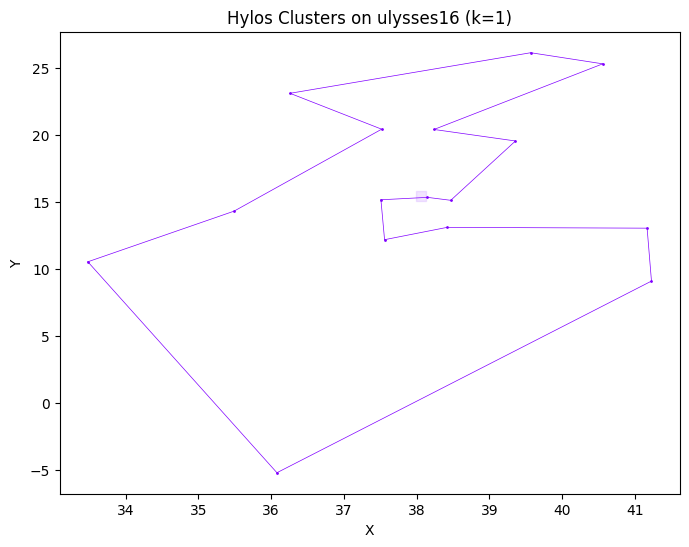

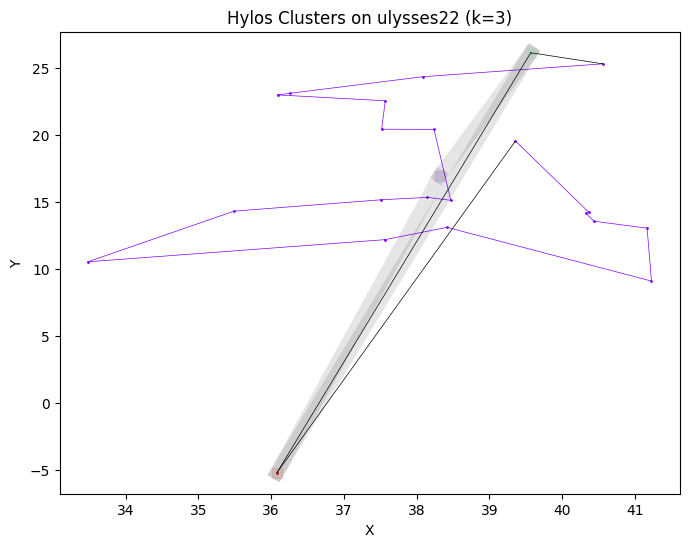

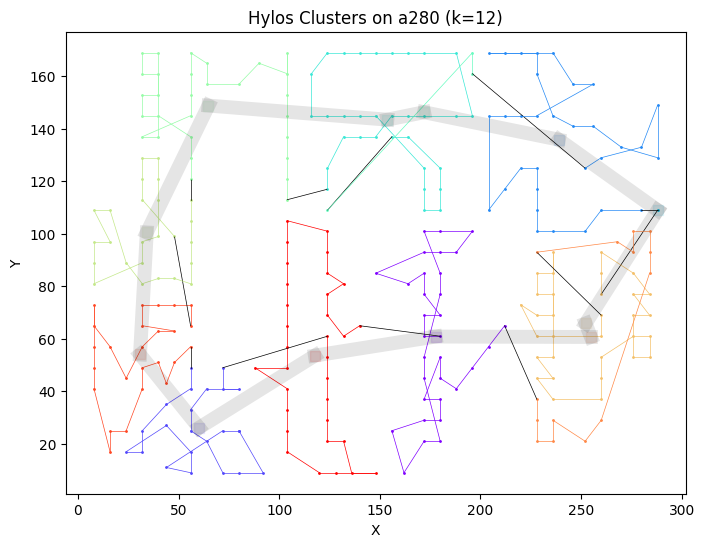

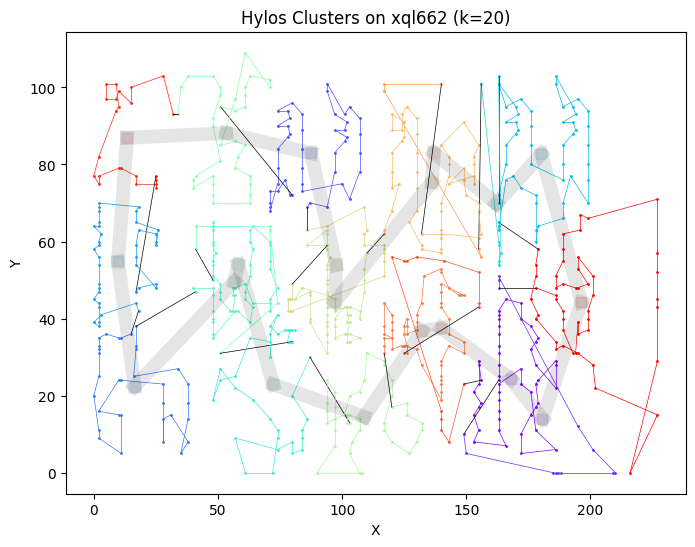

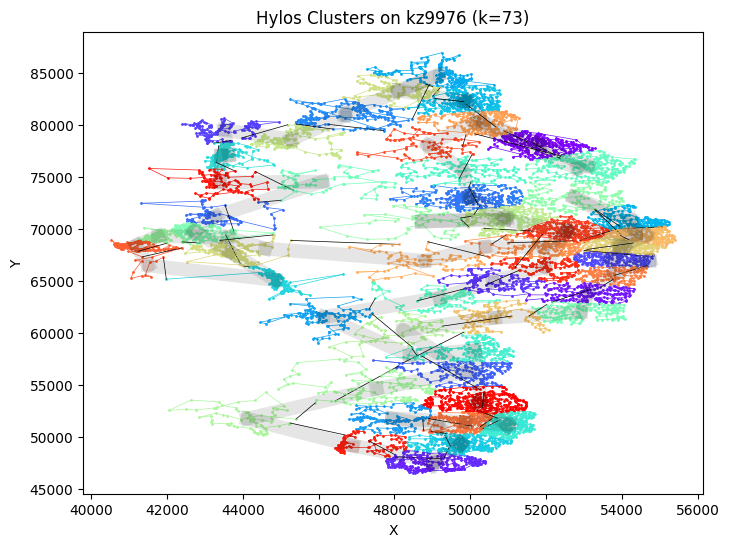

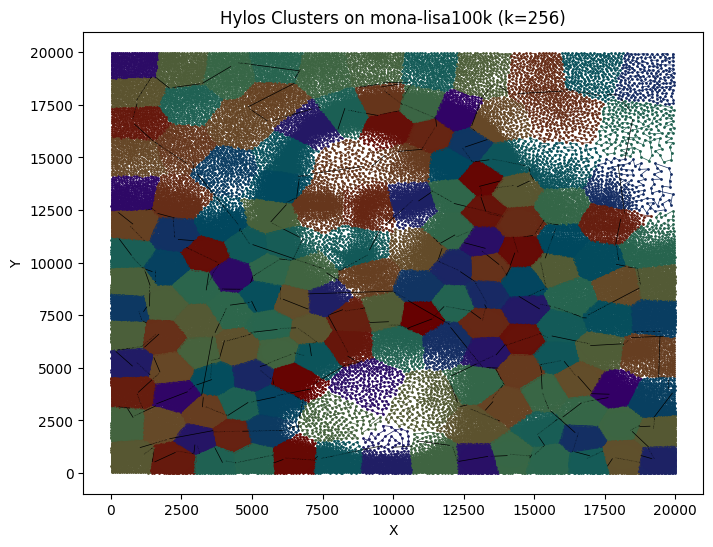

In [4]:
algorithm = 'hylos'
datasets = ['ulysses16', 'ulysses22', 'a280', 'xql662', 'kz9976', 'mona-lisa100k']
for dataset in datasets:
  plot_hylos_tour(dataset, markersize=1)

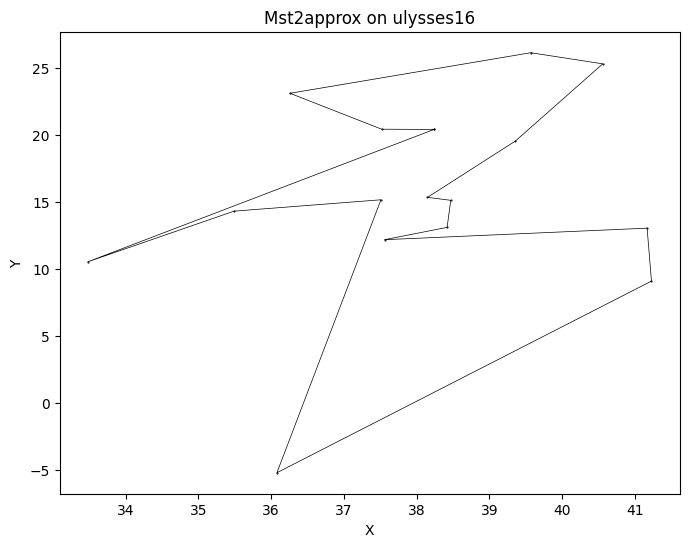

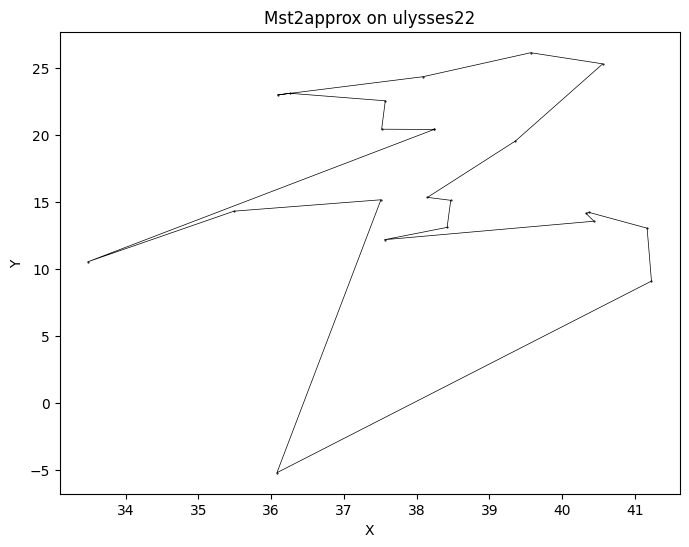

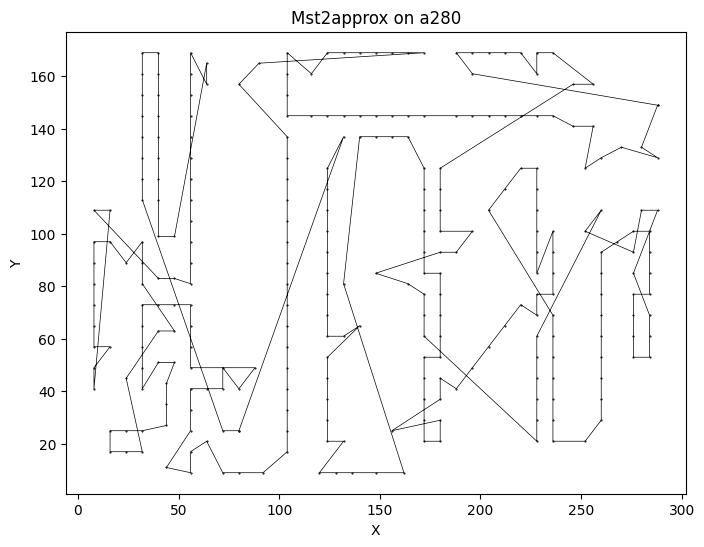

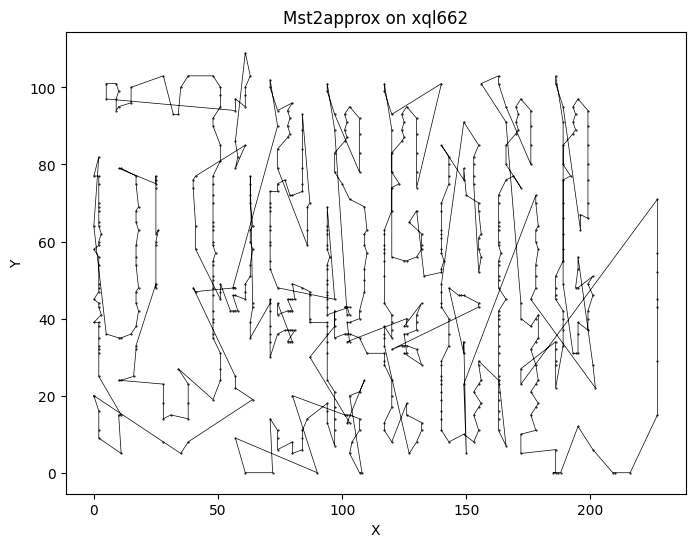

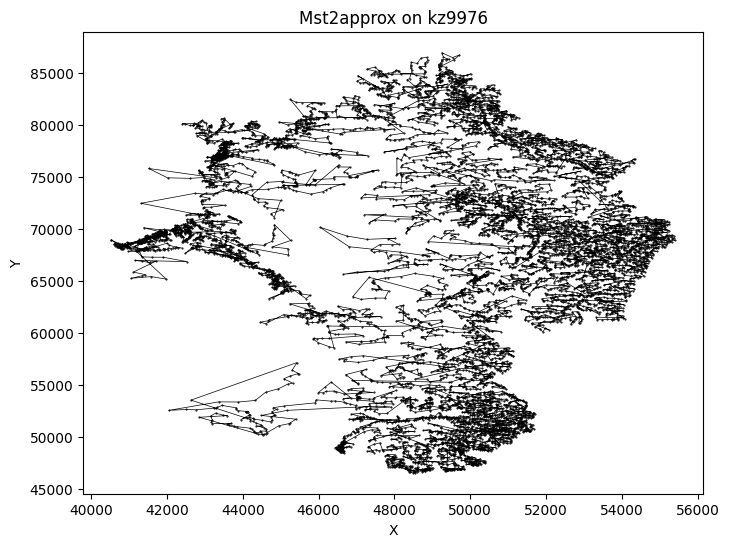

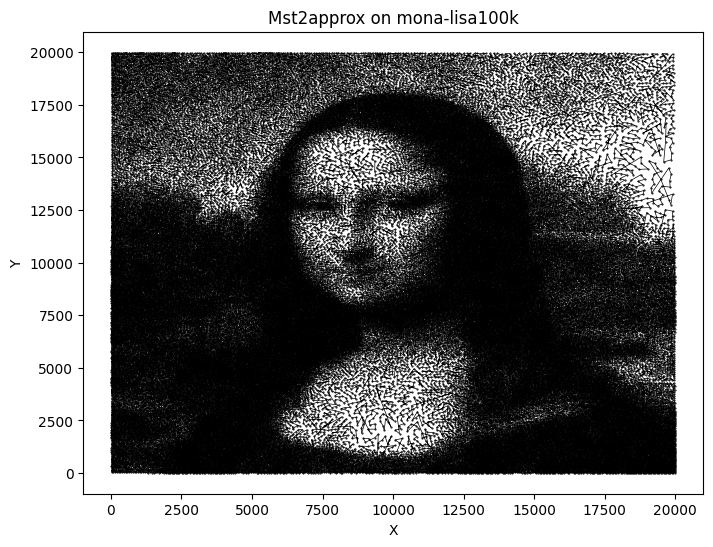

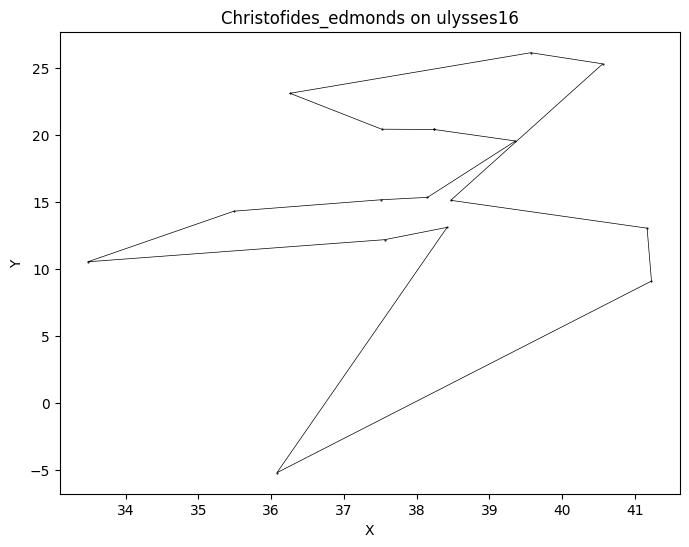

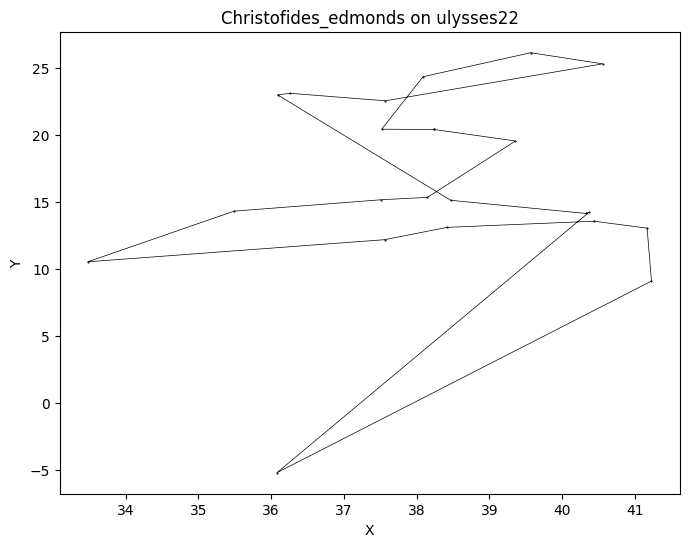

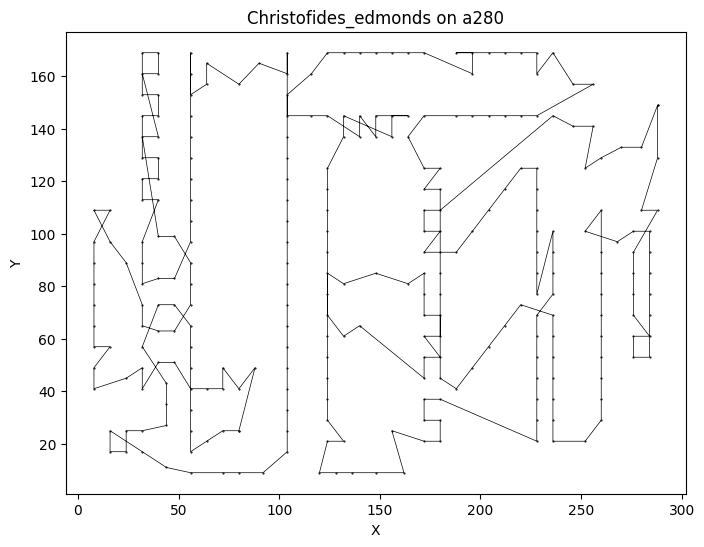

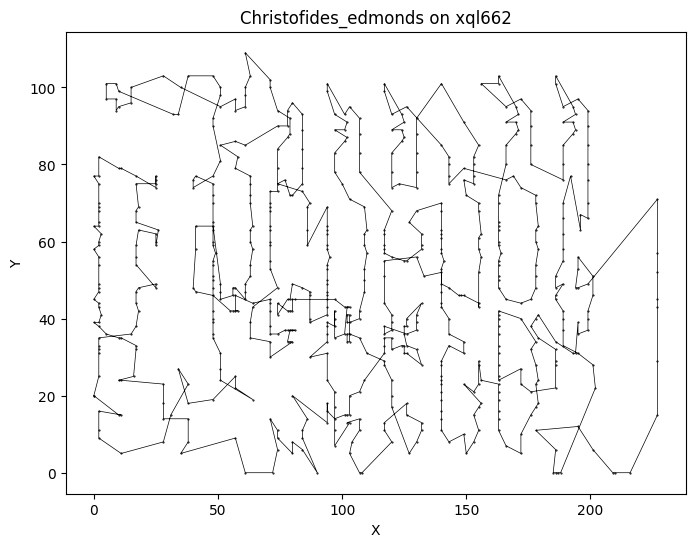

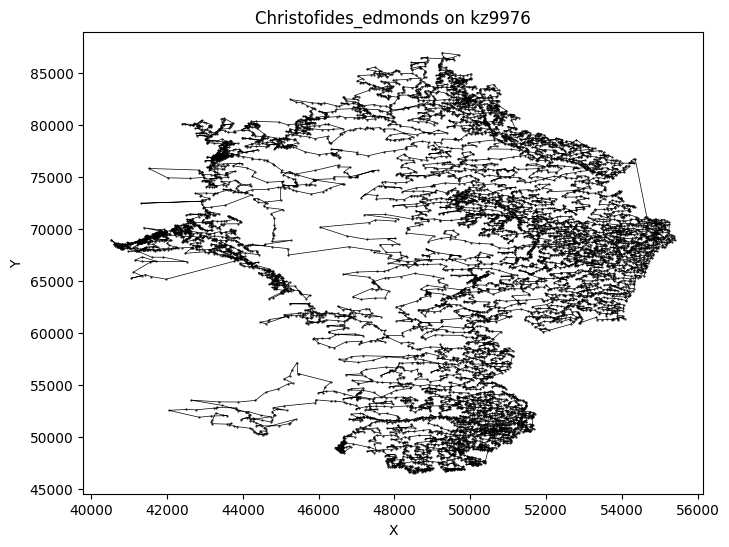

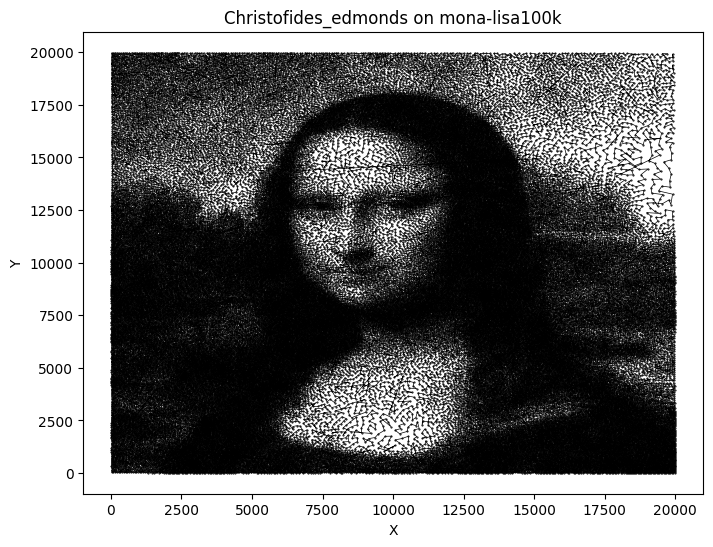

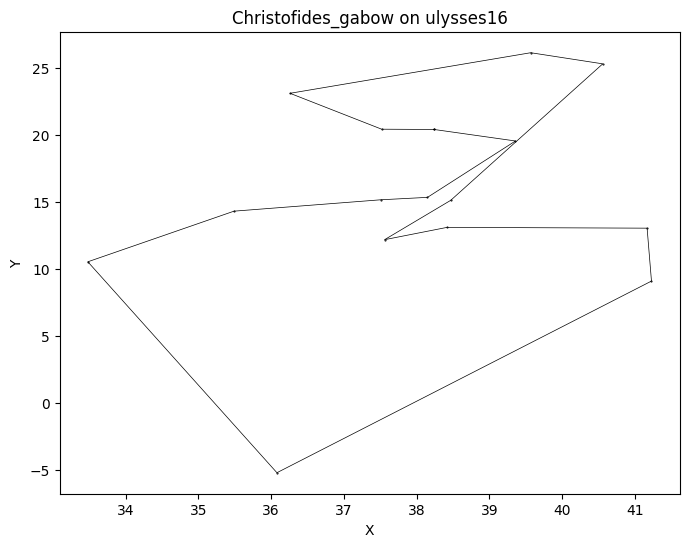

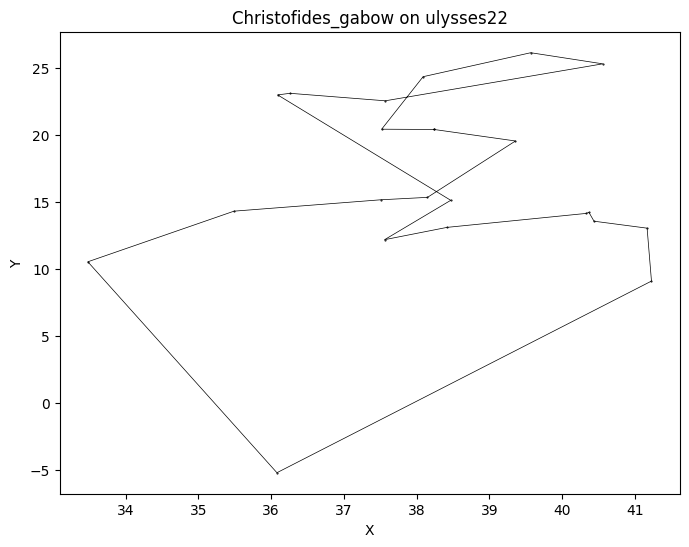

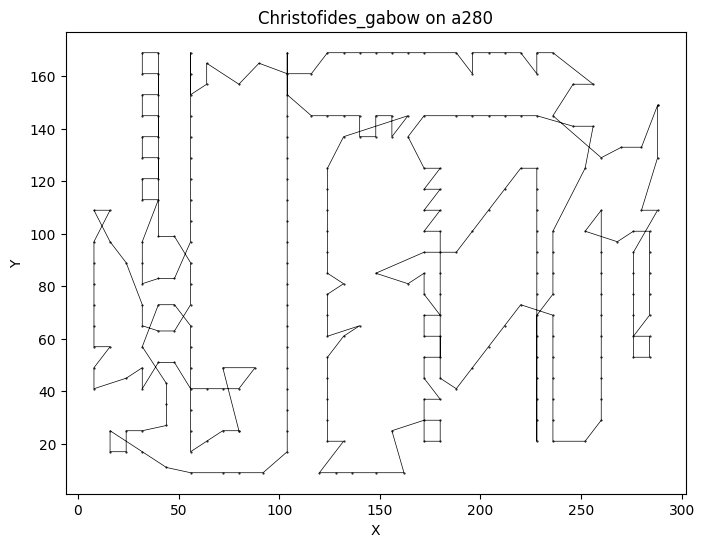

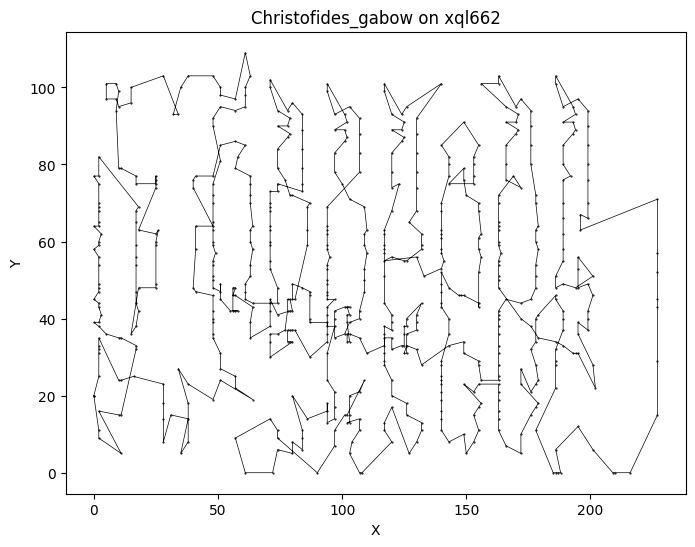

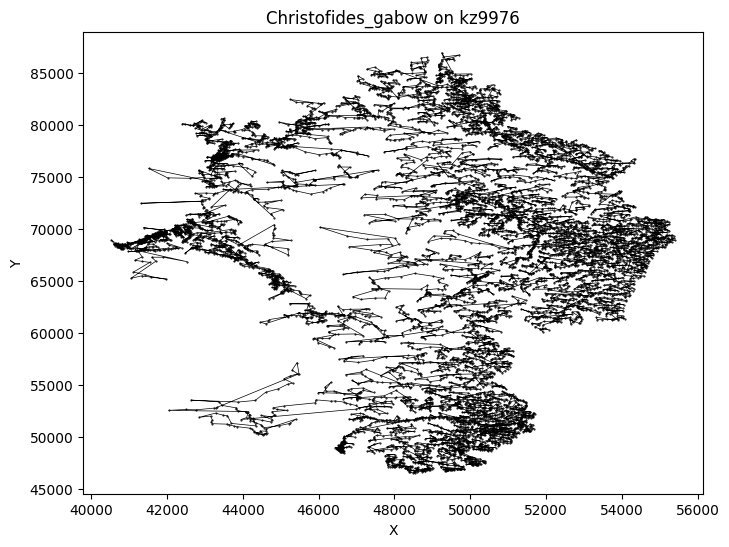

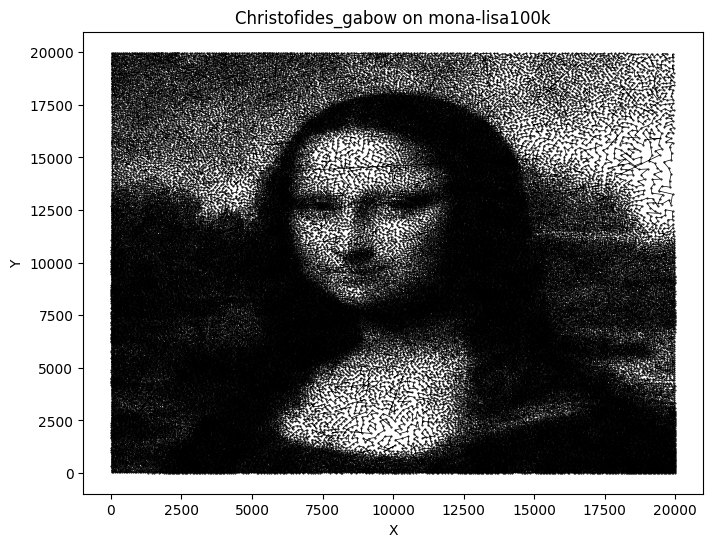

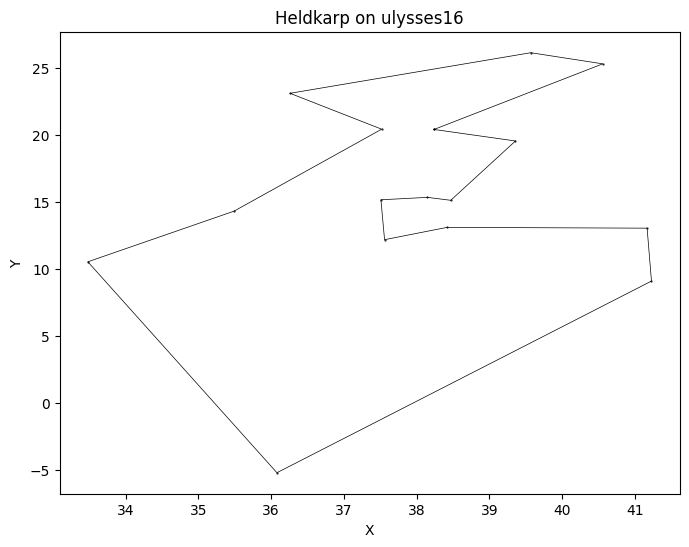

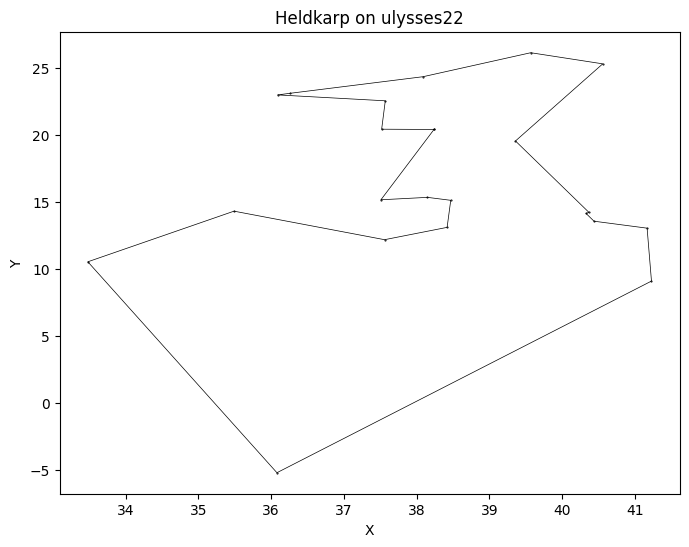

In [10]:
algorithms = ['mst2approx', 'christofides_edmonds', 'christofides_gabow', 'heldkarp']
datasets = ['ulysses16', 'ulysses22', 'a280', 'xql662', 'kz9976', 'mona-lisa100k']

for algorithm in algorithms:
    for dataset in datasets:
        coords = read_tsp_coords(f'../data/{dataset}.tsp')
        tour = read_tour(f'../result/{algorithm}_{dataset}.tour')
        if tour is not None:
            plot_tour(coords, tour, f'{algorithm.capitalize()} on {dataset}', markersize=1, linewidth=0.5)